## Hierarchical Models


In [1]:
import pandas as pd 
import numpy as np
import arviz as az
import pymc as pm
import palmerpenguins as pp
import scipy.stats as stats
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

2024-01-24 18:03:19.876179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

In [4]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")

salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

In [5]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

,customers,sales,Food_Category
0,31,459.895203,Pizza
1,31,401.147736,Pizza
2,31,413.345245,Pizza
3,31,371.909241,Pizza
4,32,433.797089,Pizza
...,...,...,...
463,100,611.736816,Sandwich
464,100,667.152954,Sandwich
465,42,331.625702,Salad
466,66,520.900940,Salad


In [6]:
customers = sales_df["customers"].values
sales_observed = sales_df["sales"].values
food_category = pd.Categorical(sales_df["Food_Category"])

In [8]:
with pm.Model() as model_hierarchical_sales:
 sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", 20)
 sigma = pm.HalfNormal("sigma", sigma_hyperprior, shape=3)

 beta = pm.Normal("beta", mu= 10, sigma= 20, shape=3)

 mu = pm.Deterministic("mu", beta[food_category.codes]*customers)

 sales = pm.Normal("sales", mu=mu, sigma=sigma[food_category.codes], observed=sales_observed)

 idata_hierarchical_sales = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_hyperprior, sigma, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
with model_hierarchical_sales:
    idata_hierarchical_sales = pm.sample_posterior_predictive(idata_hierarchical_sales, extend_inferencedata= True)

Sampling: [sales]


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'sigma_hyperprior'}>,
        <AxesSubplot:title={'center':'sigma_hyperprior'}>],
       [<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n0'}>],
       [<AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>],
       [<AxesSubplot:title={'center':'sigma\n2'}>,
        <AxesSubplot:title={'center':'sigma\n2'}>]], dtype=object)

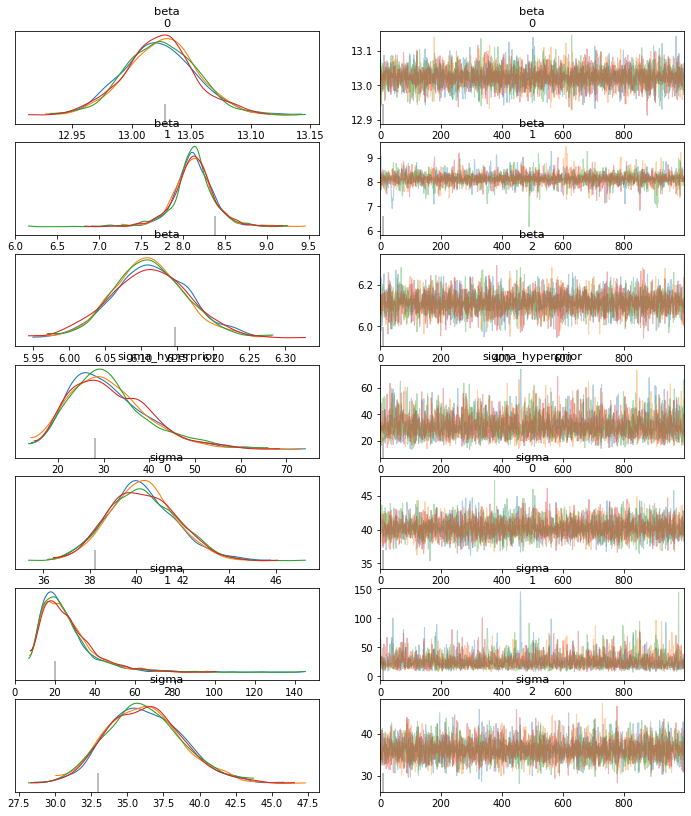

In [12]:
az.plot_trace(idata_hierarchical_sales, var_names=["beta", "sigma_hyperprior", "sigma"], compact=False)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

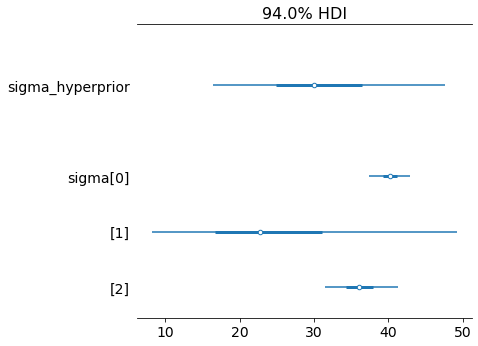

In [16]:
az.plot_forest(idata_hierarchical_sales, var_names=["sigma_hyperprior", "sigma"], combined= True)

In [17]:
az.summary(idata_hierarchical_sales, var_names=["beta", "sigma_hyperprior", "sigma"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
beta[0],13.02,0.03,12.97,13.08
beta[1],8.13,0.26,7.65,8.63
beta[2],6.11,0.05,6.01,6.21
sigma_hyperprior,31.40,8.82,16.50,47.67
sigma[0],40.26,1.45,37.46,42.88
sigma[1],25.78,13.15,8.25,49.20
sigma[2],36.22,2.61,31.54,41.34


In [18]:
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [22]:
def salad_generator(hyperprior_beta_mean=5, hyperprior_beta_sigma=.2, sigma=50, days_per_location=[6, 4, 15, 10, 3, 5], sigma_per_location=[50,10,20,80,30,20]):
    """Generate noisy salad data"""
    beta_hyperprior = stats.norm(hyperprior_beta_mean, hyperprior_beta_sigma)
    
    # Generate demands days per restaurant
    df = pd.DataFrame()
    for i, days in enumerate(days_per_location):
        np.random.seed(0)

        num_customers = stats.randint(30, 100).rvs(days)
        sales_location = beta_hyperprior.rvs()*num_customers + stats.norm(0, sigma_per_location[i]).rvs(num_customers.shape)

        location_df = pd.DataFrame({"customers":num_customers, "sales":sales_location})
        location_df["location"] = i
        location_df.sort_values(by="customers", ascending=True)
        df = pd.concat([df, location_df])
        
    df.reset_index(inplace=True, drop=True)
    return df
hierarchical_salad_df = salad_generator()

In [23]:

def gen_hierarchical_salad_sales(input_df, beta_prior_fn, dtype=tf.float32):
    customers = tf.constant(input_df["customers"].values, dtype=dtype)
    location_category = input_df["location"].values
    sales = tf.constant(input_df["sales"].values, dtype=dtype)

    @tfd.JointDistributionCoroutine
    def model_hierarchical_salad_sales():
        beta_mu_hyperprior = yield root(tfd.Normal(0, 10, name="beta_mu"))
        beta_sigma_hyperprior = yield root(tfd.HalfNormal(.1, name="beta_sigma"))
        beta = yield from beta_prior_fn(beta_mu_hyperprior, beta_sigma_hyperprior)

        sigma_hyperprior = yield root(tfd.HalfNormal(30, name="sigma_prior"))
        sigma = yield tfd.Sample(tfd.HalfNormal(sigma_hyperprior), 6, name="sigma")

        loc = tf.gather(beta, location_category, axis=-1) * customers
        scale = tf.gather(sigma, location_category, axis=-1)
        sales = yield tfd.Independent(tfd.Normal(loc, scale),
                                      reinterpreted_batch_ndims=1,
                                      name="sales")

    return model_hierarchical_salad_sales, sales

In [24]:
def centered_beta_prior_fn(hyper_mu, hyper_sigma):
    β = yield tfd.Sample(tfd.Normal(hyper_mu, hyper_sigma), 6, name="beta")
    return β

# hierarchical_salad_df is the generated dataset as pandas.DataFrame
centered_model, observed = gen_hierarchical_salad_sales(
    hierarchical_salad_df, centered_beta_prior_fn)

In [21]:
run_mcmc = tf.function(
 tfp.experimental.mcmc.windowed_adaptive_nuts,
 autograph=False,
 jit_compile=True
)

In [25]:
mcmc_samples_centered, sampler_stats_centered = run_mcmc(
    1000, centered_model, n_chains=4, num_adaptation_steps=1000,
    sales=observed)

divergent_per_chain = np.sum(sampler_stats_centered["diverging"], axis=0)
print(f"""There were {divergent_per_chain} divergences after tuning per chain.""")

2024-01-24 18:32:15.011688: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2024-01-24 18:32:15.294373: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1706117559.203308       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-24 18:32:39.630913: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


There were [24 23 53 21] divergences after tuning per chain.
